In [35]:
import multiprocessing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, models
import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from PIL import Image
from tqdm import tqdm

In [36]:
!nvidia-smi

Sat Jun 15 23:51:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.33.01              Driver Version: 546.29       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   61C    P8               2W /  75W |   5929MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [37]:
os.listdir('food-101/images')

['.DS_Store',
 'apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisq

In [38]:
os.listdir('food-101/meta')

['classes.txt',
 'labels.txt',
 'test.json',
 'test.txt',
 'train.json',
 'train.txt']

In [39]:
#image prepatation
def preparate_data(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()
    images = []
    img_dir = "./food-101/images/"
    full_path = [img_dir + img + ".jpg" for img in array]
    
    for img in array:
        img = img.split('/')

        images.append(img)

    images = np.array(images)
    images = pd.DataFrame(images[:,0], images[:,1], columns=['label'])
    images['path'] = full_path

    images = shuffle(images)

    return images

In [40]:
train_imgs = preparate_data('./food-101/meta/train.txt')
test_imgs = preparate_data('./food-101/meta/test.txt')

train_imgs.sample(10)

,label,path
1741689,tuna_tartare,./food-101/images/tuna_tartare/1741689.jpg
2869618,filet_mignon,./food-101/images/filet_mignon/2869618.jpg
1427986,waffles,./food-101/images/waffles/1427986.jpg
2600980,huevos_rancheros,./food-101/images/huevos_rancheros/2600980.jpg
2981031,french_onion_soup,./food-101/images/french_onion_soup/2981031.jpg
3862289,grilled_salmon,./food-101/images/grilled_salmon/3862289.jpg
1714901,sushi,./food-101/images/sushi/1714901.jpg
135914,gnocchi,./food-101/images/gnocchi/135914.jpg
42125,steak,./food-101/images/steak/42125.jpg
386052,fish_and_chips,./food-101/images/fish_and_chips/386052.jpg


Text(0.5, 1.0, 'chicken_wings')

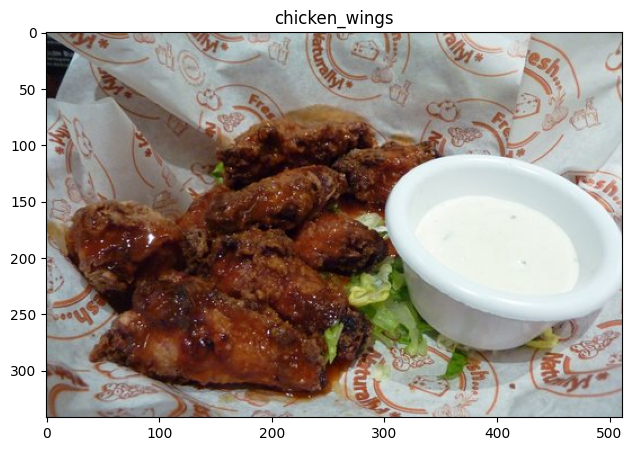

In [41]:
plt.figure(figsize=(10, 5))
img = plt.imread(train_imgs.path.iloc[122])
label = train_imgs.label.iloc[122]  
plt.imshow(img)
plt.title(label)

In [42]:
train_imgs

,label,path
3582370,sushi,./food-101/images/sushi/3582370.jpg
3770174,shrimp_and_grits,./food-101/images/shrimp_and_grits/3770174.jpg
3254989,strawberry_shortcake,./food-101/images/strawberry_shortcake/3254989...
973682,french_fries,./food-101/images/french_fries/973682.jpg
453932,french_onion_soup,./food-101/images/french_onion_soup/453932.jpg
...,...,...
3091704,poutine,./food-101/images/poutine/3091704.jpg
660733,gnocchi,./food-101/images/gnocchi/660733.jpg
3488658,mussels,./food-101/images/mussels/3488658.jpg
2168345,churros,./food-101/images/churros/2168345.jpg


In [43]:
#data augmentation
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [44]:
class Label_encoder:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(classes)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]
classes = open("./food-101/meta/classes.txt", 'r').read().splitlines()
encoder = Label_encoder(classes)
for i in range(20):
    print(encoder.get_label(i), encoder.get_idx( encoder.get_label(i) ))

apple_pie 0
baby_back_ribs 1
baklava 2
beef_carpaccio 3
beef_tartare 4
beet_salad 5
beignets 6
bibimbap 7
bread_pudding 8
breakfast_burrito 9
bruschetta 10
caesar_salad 11
cannoli 12
caprese_salad 13
carrot_cake 14
ceviche 15
cheesecake 16
cheese_plate 17
chicken_curry 18
chicken_quesadilla 19


In [45]:
class FoodDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.image_paths = []
        self.labels = []
        classes = open("./food-101/meta/classes.txt", 'r').read().splitlines()

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        img_name = self.df.path.iloc[index]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = encoder.get_idx(self.df.label.iloc[index])

        if self.transform:
            image = self.transform(image)
        return image, label


train_dataset = FoodDataset(train_imgs, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = FoodDataset(test_imgs, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [46]:
train_loader

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
model = models.efficientnet_v2_s(weights = weights)

model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [48]:
device

device(type='cuda')

In [49]:
model.load_state_dict(torch.load('effnet.pth'))

<All keys matched successfully>

In [50]:
#hyperparametrs
num_epochs = 1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, betas=[0.9, 0.999])
#обучение на гпу
model = model.to(device)

In [51]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    
    model.train()
    train_loss, accuracy = 0, 0

    print("--> Training Progress")
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        images, labels = X.to(device), y.to(device)
        y_pred = model(images)
        
        loss = loss_fn(y_pred, labels)
        train_loss += loss.item()   
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        accuracy += (y_pred_class == labels).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    accuracy = accuracy / len(dataloader)
    return train_loss, accuracy

In [52]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):

    model.eval()
    test_loss, test_acc = 0, 0


    with torch.inference_mode():
        print("--> Testing Progress")
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            images, labels = X.to(device), y.to(device)

            test_pred_logits = model(images)

            loss = loss_fn(test_pred_logits, labels)
            test_loss += loss.item()
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)

            test_acc += ((test_pred_labels == labels).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [53]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
    history = {
                "train_loss": [],
                "train_acc": [],
                "test_loss": [],
                "test_acc": []
              }

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))

        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,                                  
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)

        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
              f"\n\n=============================\n")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

    return model, history

In [ ]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, num_epochs, device)

In [54]:
def evaluate(model, dataloader):

    random = np.random.randint(0, len(dataloader))

    with torch.no_grad():
        model.eval()
        n_correct = 0
        n_samples = 0

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        preds = torch.argmax(torch.softmax(outputs, 1), 1)


        preds = np.array([pred.cpu() for pred in preds])
        labels = np.array([label.cpu() for label in labels])

        n_samples += labels.shape[0]
        n_correct += (preds==labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(acc)

In [55]:
evaluate(model,test_loader)

100%|███████████████████████████████████████████████████████████████████████████████| 1579/1579 [06:19<00:00,  4.16it/s]

86.25346534653465


In [56]:
torch.save(model.state_dict(), 'effnet_fin.pth')